In [1]:
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount("/content/gdrive")

from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau



Mounted at /content/gdrive


# Load Dataset

In [2]:
x_train = np.load('gdrive/My Drive/Colab Notebooks/Unet/CT_lung_segmentation-master/dataset/x_train.npy')
#x_train = np.load('dataset/x_train.npy')
y_train = np.load('gdrive/My Drive/Colab Notebooks/Unet/CT_lung_segmentation-master/dataset/y_train.npy')
#y_train = np.load('dataset/y_train.npy')
x_val = np.load('gdrive/My Drive/Colab Notebooks/Unet/CT_lung_segmentation-master/dataset/x_val.npy')
#x_val = np.load('dataset/x_val.npy')
y_val = np.load('gdrive/My Drive/Colab Notebooks/Unet/CT_lung_segmentation-master/dataset/y_val.npy')
#y_val = np.load('dataset/y_val.npy')

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(240, 256, 256, 1) (240, 256, 256, 1)
(27, 256, 256, 1) (27, 256, 256, 1)


# Build Model

In [3]:
inputs = Input(shape=(256, 256, 1))

net = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(64, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(128, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Dense(128, activation='relu')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(128, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(64, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
outputs = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 'mse'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856 

# Train

In [4]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=32, callbacks=[
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05) # 1epoch = 135seconds to execute, total 100 epoches takes 4 hrs
])

Epoch 1/50
8/8 [==============================] - 138s 17s/step - loss: 0.5738 - acc: 0.7498 - mse: 0.1842 - val_loss: 0.4991 - val_acc: 0.7631 - val_mse: 0.1622 - lr: 0.0010
Epoch 2/50
8/8 [==============================] - 132s 16s/step - loss: 0.4853 - acc: 0.7498 - mse: 0.1595 - val_loss: 0.4557 - val_acc: 0.7631 - val_mse: 0.1503 - lr: 0.0010
Epoch 3/50
8/8 [==============================] - 132s 16s/step - loss: 0.4467 - acc: 0.7498 - mse: 0.1489 - val_loss: 0.4187 - val_acc: 0.7631 - val_mse: 0.1396 - lr: 0.0010
Epoch 4/50
8/8 [==============================] - 133s 17s/step - loss: 0.4279 - acc: 0.7484 - mse: 0.1430 - val_loss: 0.4251 - val_acc: 0.7631 - val_mse: 0.1449 - lr: 0.0010
Epoch 5/50
8/8 [==============================] - 133s 17s/step - loss: 0.4158 - acc: 0.7494 - mse: 0.1403 - val_loss: 0.3811 - val_acc: 0.7606 - val_mse: 0.1271 - lr: 0.0010
Epoch 6/50
8/8 [==============================] - 134s 17s/step - loss: 0.4316 - acc: 0.7392 - mse: 0.1467 - val_loss: 0.4814

# Evaluation

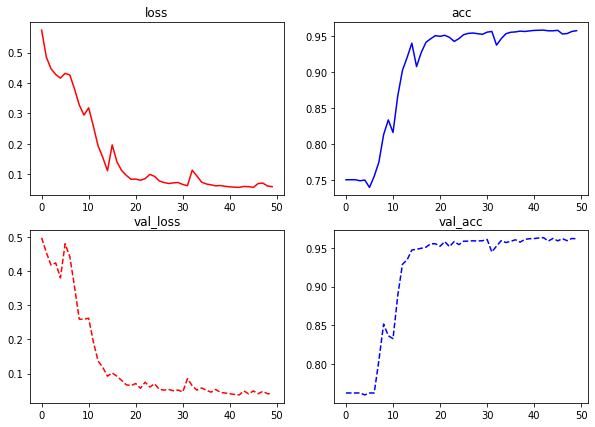

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('acc')
ax[0, 1].plot(history.history['acc'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_acc')
ax[1, 1].plot(history.history['val_acc'], 'b--')

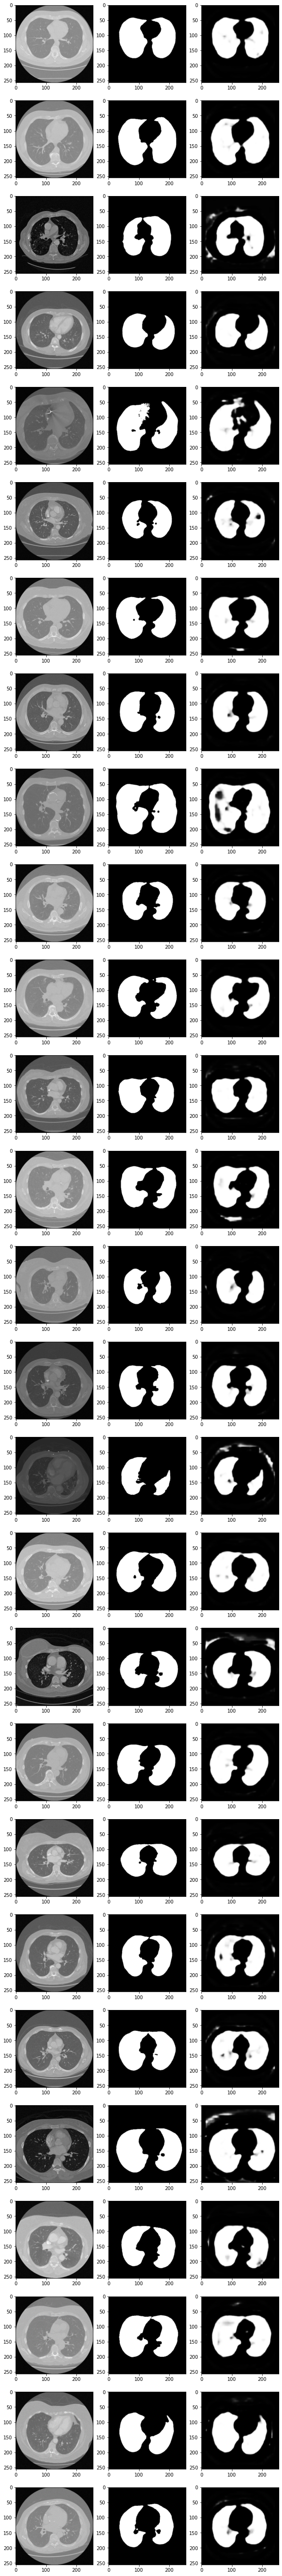

In [6]:
preds = model.predict(x_val)

fig, ax = plt.subplots(len(x_val), 3, figsize=(10, 100))

for i, pred in enumerate(preds):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')